# Predict time series using trained model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd

Using TensorFlow backend.


In [2]:
data_folder = '../Data/Npy'
fn_prec = '01_prec_training.npy'
fn_temp = '01_temp_training.npy'
fn_mask = '01_mask.npy'
#data_elev = 'Npy/01_dem.npy'
fn_disc = '01_discharge_training.csv'

- import **deephydro module** with networks, losses and metrics

In [3]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

#from deephydro.utils import limit_gpu_memory
#limit_gpu_memory()

# Data import

- load output data

In [4]:
def load_csv_data_win(data_folder:str, filename:str):
    '''Load streamflow data from CSV (.csv).

    Args:
        data_folder:str
            path to filename
        filename:str
            filename (.csv)
    Returns:
        pandas DataFrame:
            df['Q']: streamflow
            df['DOY']: Day of year (0 - 366)
            df['FDOY']: Fractional day of year (0.0 - 1.0)
    '''
    # read csv file
    df = pd.read_csv(data_folder+'/'+ filename)
    # day of year
    df['DOY'] = pd.DatetimeIndex(df['Time']).dayofyear
    # calculate fractional day of year
    df['FDOY'] = pd.DatetimeIndex(df['Time']).dayofyear / 366
    return df

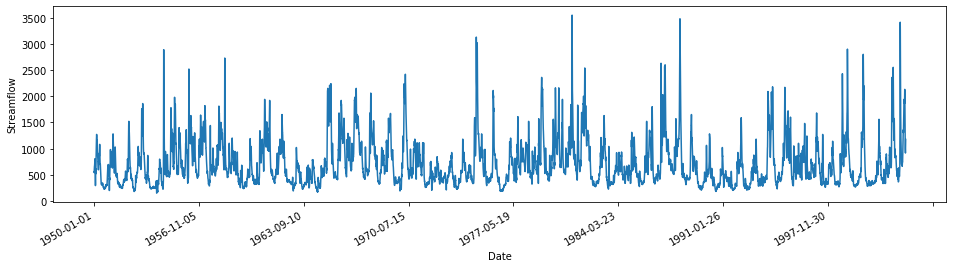

In [5]:
from deephydro import data, visualization
df = load_csv_data_win(data_folder=data_folder, filename=fn_disc)
df.head()
visualization.plot_streamflow(df=df)#, n_labels=20)

- load input data

In [6]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)

In [7]:
print(f'x_prec.shape = {x_prec.shape}')
print(f'x_temp.shape = {x_temp.shape}')
print(f'x_mask.shape = {x_mask.shape}')

x_prec.shape = (19358, 53, 66)
x_temp.shape = (19358, 53, 66)
x_mask.shape = (53, 66)


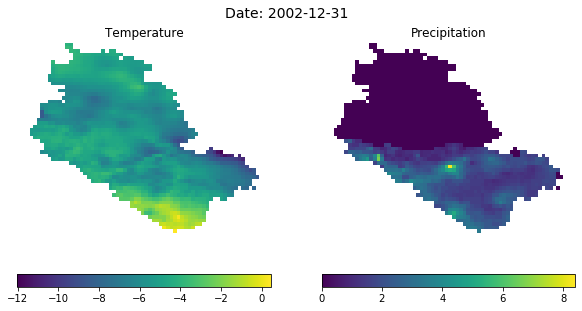

In [8]:
visualization.plot_temp_prec_frame(x_temp, x_prec, x_mask, df, 
                                   frame=-1)


# Data preparation

- define input data `x` and targets `y`

In [9]:
# x: stack temperature and precipitation data
x = np.stack([x_temp, x_prec], axis=-1)

# x: fractional day of year data
x_doy = df['FDOY'].values

# y: streamflow data
y = df['Q'].values

- split train and validation data

In [10]:
# split train and validation data
validation_fraction=0.2
validation_first=False

x_train, x_val, y_train, y_val = \
  data.split_train_validation(x, y, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

x_doy_train, x_doy_val = data.split_DOY_train_validation(x_doy,  
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

df_train, df_val = data.split_df_train_validation(df, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)


In [11]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_val   = ', x_val.shape)
print('Shape of y_val   = ', y_val.shape)

Shape of x_train =  (15487, 53, 66, 2)
Shape of y_train =  (15487,)
Shape of x_val   =  (3871, 53, 66, 2)
Shape of y_val   =  (3871,)


- standardize input (`x_train`) and output data (`y`)

In [12]:
x_train = data.standardize_input_data(x_train)
x_val   = data.standardize_input_data(x_val)

In [13]:
y_train, (Y_MEAN, Y_STD) = data.standardize_targets(y_train)
y_val, _ = data.standardize_targets(y_val)

In [14]:
print(f'Y_MEAN = {Y_MEAN:.3f}')
print(f'Y_STD  = {Y_STD:.3f}')
print('Shape of y = ', y_train.shape)


Y_MEAN = 715.437
Y_STD  = 426.762
Shape of y =  (15487,)


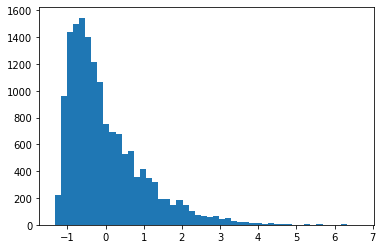

In [15]:
_ = plt.hist(y_train, bins=50)

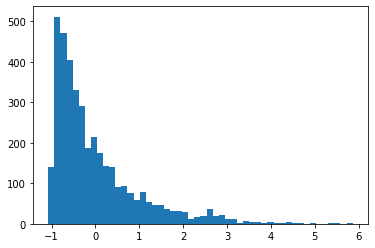

In [16]:
_ = plt.hist(y_val, bins=50)

# Predict

In [17]:
model_name = '../output/model_wdb_doy_nobatchnorm_dropout.h5' #model_wdb_log_dropout_batchnorm.h5'

n_frames = 70
Y_MEAN = 715.437
Y_STD  = 426.762

In [18]:
reload_model = True

if reload_model:
    from keras.models import load_model
    from deephydro.metrics import ccc
    model = load_model(model_name, 
               custom_objects={'ccc': ccc})

- predict time series

In [ ]:
# kernel dies at this cell
from deephydro.inference import predict_timeseries

maxtime = len(x_val)//10
ts_pred, ts_gt, df_pred = predict_timeseries(model=model, 
                                    data=x_val[:maxtime], 
                                    doy=x_doy_val[:maxtime], 
                                    df=df_val[:maxtime],
                                    n_frames=n_frames, 
                                    stride=1, 
                                    batch_size=32, #256, 
                                    #y_mean=Y_MEAN, y_std=Y_STD,
                                    gt=y_val[:maxtime], 
                                    plot=True,
                                            n_gpus=1)

0 / 317


In [ ]:
df_pred

In [ ]:
from deephydro.visualization import plot_correlation
plot_correlation(ts_pred, ts_gt)

- predict random samples

In [ ]:
df_pred.head()

# from deephydro.utils import predict_batch
# gt, y_pred, df = predict_batch(model, generator=generator_test, 
#                      n_samples=2000, y_mean=Y_MEAN, y_std=Y_STD)

# df_pred.to_csv('../output/df_pred.csv')

In [ ]:
# from deephydro.visualization import plot_correlation
# plot_correlation(gt, y_pred)

# Dynamic time warping (DTW) distance

between predicted and measured streamflow time series

In [ ]:
!pip install --user fastdtw

In [ ]:
%%time
import pandas as pd
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

#df_pred = pd.read_csv('../output/df_pred.csv')

gt   = df_pred['Q'].values
pred = df_pred['Q_pred'].values

distance, path = fastdtw(gt, pred, radius=len(gt)//100, dist=euclidean)
print(distance)


In [ ]:
len(gt) // 100: 277584.0145602375

In [ ]:
len(gt) // 10: 277584.0145602375


In [ ]:
len(gt): 330060.2269075579


In [ ]:
330060.2269075579

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

In [ ]:
path

In [ ]:
# 1992-05-28
module_folder = os.path.abspath('../saliency_trials')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
from saliency_scr import *

In [ ]:
df_ind = df[df.Time=='1992-05-28'].index[0]
print(df_ind)
x[df_ind]
june10 =np.stack([x[df_ind-n_frames+1:df_ind+1][...,0], x[df_ind-n_frames+1:df_ind+1][...,1]], axis=-1)
june10pred=df_pred[df_pred.Time=='1992-05-28'].Q_pred#predict(model, image=june10, y_mean=Y_MEAN, y_std=Y_STD)
gradcam_june10 =grad_convlstm(realmodel, june10,june10pred, 
                         #prop_from_layer,
                         prop_to_layer='conv_lst_m2d_18', 
                         normalize=False)
plot_gradcams_all_frames(gradcam_june10,mask)

In [ ]:
x[df_ind].shape

In [ ]:
realmodel =model.layers[-2]#.summary()

In [ ]:
realmodel.summary()

In [ ]:
realmodel.get_input_at(0)[0]

In [ ]:
june10.shape

In [ ]:
x[df_ind].shape

In [ ]:
x_val.shape

In [ ]:
def grad_convlstm(input_model, image,predictions, 
                         #prop_from_layer,
                         prop_to_layer='conv_lst_m2d_2', 
                         normalize=True,abs_w=False,posit_w=False):
    """GradCAM that works for regression output & multidim input for lstm model """
    print(image.shape)
    preprocessed_input = tuple([np.expand_dims(image, 0),0.4])#load_image(img_path)
    preprocessed_input2 = np.array(preprocessed_input, dtype=np.float32)
    #print("preprocessed_input.shape ",preprocessed_input.shape)
    #img = np.expand_dims(img, 0)
    #predictions = input_model.predict(preprocessed_input)
    #print(predictions)
    #predicted_class = predictions    
    realmodel =model.layers[-2]
    prop_from_layer = input_model.layers[-1].name #last dense
    #prop_to_layer = input_model.layers[3].name #first convlstm | last = -4
    print("prop_to_layer ",prop_to_layer)
    y_c = input_model.layers[-2].get_layer(prop_from_layer).output#[...,i,j,cls]
    print("y_c: ", y_c)
    conv_output = input_model.layers[-2].get_layer(prop_to_layer).output#[0]
    grads = K.gradients(y_c, conv_output)[0]
    print("grads:", grads)
    print("conv_output.shape, grads.shape: ",conv_output.shape)#, grads.shape)
    """
    Arguments:
    loss: Scalar tensor to minimize.
    variables: List of variables.
    Returns: A gradients tensor."""
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.get_input_at(0)#[0]#input#get_input_at(0) for models with more inputs than just an image
                                   ], [conv_output, grads])
    """The part of code snippet is as follows -

    final_conv_layer = get_output_layer(model, "conv5_3")
    get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
In this code, there is a model from which "conv5_3" layer is extracted (line 1). 
iN the function K.function(), first argument is input to this model and second is set of 2 
outputs - one for convolution and second for softmax output at the last layer.

As per the Keras/Tensorflow manual, this function runs the computation graph that we have created 
in the code, taking input from the first parameter and extracting the number of outputs as per the
 layers mentioned in the second parameter. Thus, conv_outputs are output of final_conv_layer and 
 predictions are output of model.layers[-1] i.e. last layer of the model.
    """
    output, grads_val = gradient_function(preprocessed_input2)#,K.tensor(0.2)])
    print("output, grads_val shapes: ",output.shape, grads_val.shape)
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    print("output, grads_val shapes: ",output.shape, grads_val.shape)
    #print("output[0, :], grads_val[0, :, :, :] ; ",output, grads_val)
    weights = np.mean(grads_val, axis=(0, 1,2))#,3)) # here's the change for our multidim images
    
    if abs_w:
        weights = abs(weights)
    if posit_w:
        weights=np.maximum(weights,0)
        
    cam = np.dot(output, weights) #*abs(grads_val) or max(grads_val,0)
    img_dim = image.shape[1:3] #works for all convlstm layers except the last since it has no temporal dim
    if Debug:
        print("image shape: ", image.shape)
        print("cam shape: ", cam.shape)
        print("img_dim: ",img_dim)
        #print("input_model.output ",input_model.output)#str(K.eval(input_model.output))) #str(y_true.eval())
        #print("y_c: ", y_c)
        #print("conv_output: ",conv_output)
        #print("K.gradients(y_c, conv_output) ", K.gradients(y_c, conv_output))
        #print("K.gradients(y_c, conv_output)[0] aka grads: ", grads)
        #print("gradient_function: ",gradient_function)
        print("output.shape, grads_val.shape: ",output.shape, grads_val.shape)
        #print("output, grads_val: ",output, grads_val)
        print("weights.shape : ",weights.shape)
    # Process CAM
    print("cam T shape: ", cam.T.shape)
    unresizedcam=cam
    cam = cv2.resize(cam.T, img_dim)#[::-1])#, cv2.INTER_LINEAR) #cv2.resize(image,(width,height))
    print("resized cam shape: ", cam.shape)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0 and normalize: 
        cam = cam / cam_max
    return cam,predicted_class, unresizedcam
gradcam_june10 =grad_convlstm(model, june10,june10pred, 
                         #prop_from_layer,
                         prop_to_layer='conv_lst_m2d_18', 
                         normalize=False)

In [ ]:
realmodel.layers[2].input

In [ ]:
model.input

In [ ]:
realmodel.input

In [ ]:
model.summary()